## __Predicción de eclipses mediante el uso de Machine Learning__

Durante toda nuestra vida, y desde los inicios mismos de nuestra historia, convivimos con este interesante y notorio fenómeno que, durante mucho tiempo, dio lugar a curiosas e interesantes historias que intentaban explicar su funcionamiento. Hoy, entendemos plenamente su funcionamiento, y, a forma de corolario de la comprensión de la mecánica celeste, somos capaces de predecirlo de forma precisa para nuestro ocio o para usarlo en investigación científica, como se hizo en 1919 para someter a prueba por primera vez la Relatividad General de Einstein.

A pesar de la fuerte comprensión teórica que se tiene actualmente sobre ese y otros fenómenos de la mecánica celeste, resulta difícil a nivel de cálculos y poder de cómputo, desarrollar algoritmos eficientes basados en nuestras teorías que sean capaces de, al mismo tiempo, obtener predicciones precisas y obtener resultados en tiempos de cómputo racionales. Por otro lado, con el actual desarrollo en el campo de la computación y el Aprendizaje Automático (Inteligencia Artificial), se ha notado que, bajo este paradigma, es posible entrenar modelos de aprendizaje que replican de forma correcta, y en tiempos de cálculo mucho más razonables, teorías y leyes físicas de nuestro universo, resultando en modelos de gran interés cuando se quiere replicar la realidad física de forma rápida (como se requiere por ejemplo en el campo de gráficos por computadora). 

Es así, como M. Sferdian, M. Frincu (2021) (https://irep.ntu.ac.uk/id/eprint/44130/), muestran la mejora computacional obtenida entre el métodos clásico implementado en un algoritmo de fuerza bruta, y el entrenamiento de un modelo de Machine Learning para la predicción de eclipses. En el trabajo actual, se replica el trabajo hecho en el artículo para entrenar el modelo de aprendizaje automático.

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from include.Calculations.aux_funcs import get_minimum_separation, get_minimum_separation_lunar
from include.ML.confusion_matrix_helper import make_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

def plot_cf_matrix(test_labels, predictions, accuracy, f1, label = ''):
    cf_matrix = confusion_matrix(test_labels, predictions)
    labels = ['True Negatives','False Positives','False Negatives','True Positives']
    categories = ['No eclipse', 'Elipse']
    make_confusion_matrix(cf_matrix,
                        accuracy = accuracy,
                        f1 = f1,
                        group_names = labels,
                        categories = categories,
                        cbar = False,
                        title = 'Confusion Matrix (' + label + ')',
                        cmap = 'Reds')

# Data retrieval, check that the data is already installed in local directory (execute include/get_data.py and check that all the files in data 
# were correctly installed)
df = pd.read_csv('data/solar-eclipses-classif.csv')
df['Is Eclipse'] = df['Is Eclipse'].replace({True: 1, False: 0}) # labels are treated as type int64
# check = df[df['Date'] == '2023-10-14'] # %Y-%M-%D date formatting
# print(check)

bias_pos = df[df['Date'] == '2019-12-31'].index.item() + 1 # sets the position of the given Date as bias for the training set
train, test = df[:bias_pos], df[bias_pos:]
train_labels, test_labels = np.array(train.pop('Is Eclipse')), np.array(test.pop('Is Eclipse'))
train.set_index('Date', inplace=True)
test.set_index('Date', inplace=True)
train, test = train.select_dtypes('number'), test.select_dtypes('number')
# test

### __K-Nearest Neighbors__

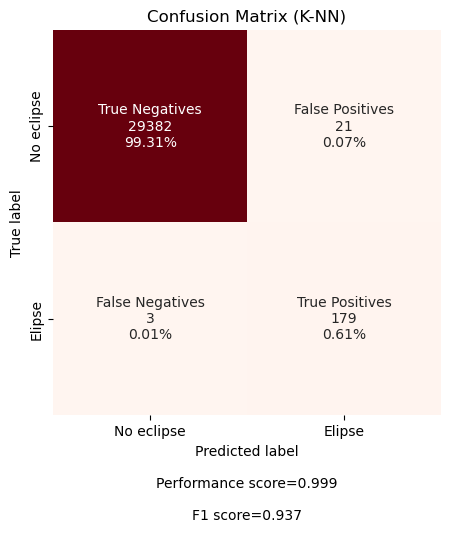

In [3]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(algorithm = 'auto',
    leaf_size = 30,
    metric = 'minkowski',
    n_neighbors = 7,
    p = 2,
    weights = 'uniform'
)
knn_model.fit(train, train_labels)

# metrics
# print(f'Model Accuracy: {knn_model.score(train, train_labels)}')
predictions = knn_model.predict(test)
accuracy = knn_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Model Score: {knn_model.score(test, test_labels)}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'K-NN')

In [4]:
date = '2023-10-14' # solar
# date = '2023-10-28' # lunar
# date = '2023-05-05' # lunar
# date = '2025-03-29' #solar
print(knn_model.predict([[get_minimum_separation(date)]])) # this function works only when predicting solar eclipses
# print(knn_model.predict([[get_minimum_separation_lunar(date)]])) # this function works only when predicting lunar eclipses

[1]


### __Logistic Regression__

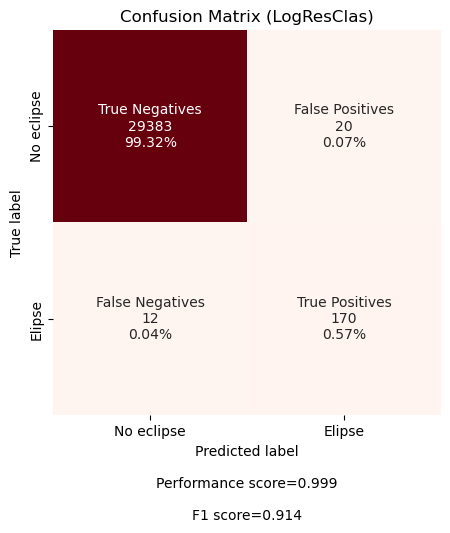

In [4]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression()
logreg_model.fit(train, train_labels)

# metrics
# print(f'Model Accuracy: {logreg_model.score(train, train_labels)}')
predictions = logreg_model.predict(test)
# print(f'Model Accuracy: {logreg_model.score(train, train_labels)}')
accuracy = logreg_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'LogResClas')

### __Random Forest Classifier__

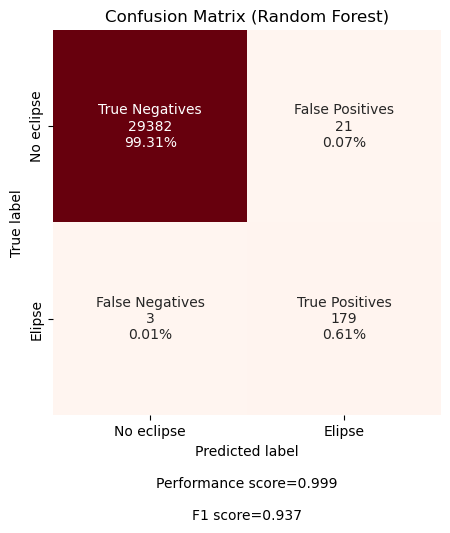

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    max_depth=2, # no overfitting
    min_samples_split=30, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None, 
    random_state=None, 
    verbose=0, 
    warm_start=False, 
    class_weight=None, 
    ccp_alpha=0.0, 
    max_samples=None
)
rf_model.fit(train, train_labels)
# print(f'Model Accuracy: {rf_model.score(test, test_labels)}')
predictions = rf_model.predict(test)
# print(f'Model Accuracy: {rf_model.score(train, train_labels)}')
accuracy = rf_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'Random Forest')

### __Multi-layer Perceptron Classifier__

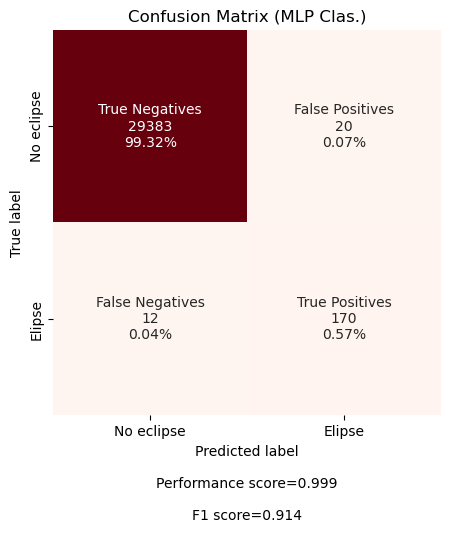

In [6]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(5,8,8), 
    activation='relu', 
    solver='adam', 
    max_iter=500)
mlp_model.fit(train,train_labels)
# print(f'Model Accuracy: {mlp_model.score(test, test_labels)}')
predictions = mlp_model.predict(test)
# print(f'Model Accuracy: {rf_model.score(train, train_labels)}')
accuracy = mlp_model.score(test, test_labels)
# print(f'Model Accuracy: {accuracy}')
# print(f'Precision: {precision_score(test_labels, predictions)}')
# print(f'Recall: {recall_score(test_labels, predictions)}')
f1 = f1_score(test_labels, predictions)
# print(f'F1 Score: {f1}')
plot_cf_matrix(test_labels, predictions, accuracy, f1, label = 'MLP Clas.')